In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import v2
from torchmetrics.classification import MulticlassAccuracy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
no_epochs = 50
learning_rate = 0.001
batch_size = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

acc_function = MulticlassAccuracy(num_classes=102, average='micro').to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

SEED = 42
np.random.seed(SEED)
gen = torch.manual_seed(SEED)

cuda:0


In [3]:
# Data Augmentation for training
train_transforms = v2.Compose([
    v2.RandomRotation(30),
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Default transforms for validation and test
default_transforms = v2.Compose([
    models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()
])

flowers_train = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
flowers_test = datasets.Flowers102(root='./data', split='test', download=True, transform=default_transforms)
flowers_val = datasets.Flowers102(root='./data', split='val', download=True, transform=default_transforms)


In [4]:
# function to create data loaders
def get_data_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(flowers_train, batch_size=batch_size, shuffle=True, generator=gen)
    test_loader = torch.utils.data.DataLoader(flowers_test, batch_size=batch_size, shuffle=True, generator=gen)
    val_loader = torch.utils.data.DataLoader(flowers_val, batch_size=batch_size, shuffle=True, generator=gen)
    return train_loader, test_loader, val_loader

In [5]:
# Early stopping based on accuracy
class AccuracyEarlyStopper:
    def __init__(self, patience=3, min_delta=0.1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_accuracy = 0

    # stop if validation accuracy is not improving
    def early_stop(self, validation_accuracy):
        if validation_accuracy > (self.max_validation_accuracy + self.min_delta):
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
# train function
def train(model, optimizer, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        # calculate loss and backpropagate
        running_loss_value += loss.item()
        loss.backward()
        optimizer.step()
    # return average loss
    return running_loss_value / len(dataloader)

# evaluate and test function
def test_eval(model, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    running_acc_value = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = acc_function(outputs, labels)
            # calculate loss and accuracy
            running_loss_value += loss.item()
            running_acc_value += acc.item()
    # return average accuracy and loss
    running_acc_value /= len(dataloader)
    running_loss_value /= len(dataloader)
    # multiplied by 100 for percentage
    return running_acc_value*100, running_loss_value

# function to train and validate model over epochs and test after training
def train_eval_test(model, train_dataloader, val_dataloader, test_dataloader, no_epochs=10):
    es = AccuracyEarlyStopper()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, training_time = [], [], [], [], []
    for i in range(no_epochs):
        # start timer to calcuate train time
        start = datetime.datetime.now()
        train_loss = train(model, optimizer, train_dataloader)
        # end timer
        end = datetime.datetime.now()
        # calculate time taken
        time_taken = (end - start).total_seconds()
        eval_acc, eval_loss = test_eval(model, val_dataloader)
        print(f'Epoch {i+1} Train Loss: {train_loss:>8f}, Eval Accuracy: {eval_acc:>0.2f}%, Eval Loss: {eval_loss:>8f}, Time Taken: {time_taken:>0.2f}s')
        train_loss_arr.append(train_loss)
        eval_loss_arr.append(eval_loss)
        eval_acc_arr.append(eval_acc)
        training_time.append(time_taken)
        if es.early_stop(eval_acc):
            print('Early stopping activated')
            break
    # test model after training
    test_acc, test_loss = test_eval(model, test_dataloader)
    print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")
    return train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, test_acc, test_loss, training_time

In [7]:
# function to create VGG model
def create_VGG_model():
    # use pretrained weights
    model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
    
    # create new classifier head for 102 classes
    new_classifier_head = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 102)
    )
    
    # freeze all layers except classifier head
    for param in model.parameters():
        param.requires_grad = False
        
    # replace classifier head
    model.classifier = new_classifier_head

    return model.to(device=device)

# fucntion to create resnet model based on size
def create_resnet_model(size=50):
    match size:
        case 18:
            # create resnet18 model with pretrained weights
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            # create new classifier head for 102 classes
            new_fc = nn.Linear(512,102)
        case 34:
            # create resnet34 model with pretrained weights
            model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
            # create new classifier head for 102 classes
            new_fc = nn.Linear(512,102)
        case 50:
            # create resnet50 model with pretrained weights
            model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            # create new classifier head for 102 classes
            new_fc = nn.Linear(2048, 102)
        case 101:
            # create resnet101 model with pretrained weights
            model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
            # create new classifier head for 102 classes
            new_fc = nn.Linear(2048,102)
        case _:
            # default to resnet50
            print("Invalid Size, defaulting to 50")
            model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            new_fc = nn.Linear(2048, 102)
    
    # freeze all layers except classifier head
    for param in model.parameters():
        param.requires_grad = False
        
    # replace classifier head
    model.fc = new_fc
    
    return model.to(device)

# function to create efficientnet model based on size
def create_efficientnet_model(size):
    match size:
        case 's':
            # create efficientnet v2 small model with pretrained weights
            model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        case 'm':
            # create efficientnet v2 medium model with pretrained weights
            model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
        case 'l':
            # create efficientnet v2 large model with pretrained weights
            model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)
        case _:
            # default to efficientnet v2 medium
            model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)

    # freeze all layers except classifier head
    for param in model.parameters():
        param.requires_grad = False
        
    # create new classifier head for 102 classes
    new_classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(1280, 102)
    )
    
    # replace classifier head
    model.classifier = new_classifier
    
    return model.to(device)

In [8]:
# initialise data loaders
train_data_loader, test_data_loader, val_data_loader = get_data_loader(batch_size)

In [9]:
# VGG16 model training
VGG_model = create_VGG_model()
print("VGG16")
VGG_train_acc, VGG_train_loss, VGG_eval_acc, VGG_eval_loss, VGG_test_acc, VGG_test_loss, VGG_training_time = train_eval_test(
    VGG_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del VGG_model

VGG16
Epoch 1 Train Loss: 4.900608, Eval Accuracy: 4.91%, Eval Loss: 4.539280, Time Taken: 12.64s
Epoch 2 Train Loss: 4.481932, Eval Accuracy: 14.60%, Eval Loss: 4.052787, Time Taken: 11.68s
Epoch 3 Train Loss: 3.891391, Eval Accuracy: 25.76%, Eval Loss: 3.145368, Time Taken: 11.75s
Epoch 4 Train Loss: 3.069711, Eval Accuracy: 34.91%, Eval Loss: 2.516913, Time Taken: 11.68s
Epoch 5 Train Loss: 2.502981, Eval Accuracy: 42.23%, Eval Loss: 2.193071, Time Taken: 12.21s
Epoch 6 Train Loss: 2.095954, Eval Accuracy: 55.02%, Eval Loss: 1.656407, Time Taken: 11.73s
Epoch 7 Train Loss: 1.674891, Eval Accuracy: 59.72%, Eval Loss: 1.464198, Time Taken: 11.86s
Epoch 8 Train Loss: 1.444852, Eval Accuracy: 63.53%, Eval Loss: 1.341081, Time Taken: 11.81s
Epoch 9 Train Loss: 1.225574, Eval Accuracy: 68.06%, Eval Loss: 1.198425, Time Taken: 11.35s
Epoch 10 Train Loss: 1.138286, Eval Accuracy: 66.08%, Eval Loss: 1.221115, Time Taken: 11.14s
Epoch 11 Train Loss: 1.095686, Eval Accuracy: 69.03%, Eval Loss:

In [10]:
# ResNet18 model training
ResNet_18_model = create_resnet_model(18)
print("RESNET18")
ResNet18_train_acc, ResNet18_train_loss, ResNet18_eval_acc, ResNet18_eval_loss, ResNet18_test_acc, ResNet18_test_loss, ResNet18_training_time = train_eval_test(
    ResNet_18_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del ResNet_18_model

RESNET18
Epoch 1 Train Loss: 4.731230, Eval Accuracy: 6.86%, Eval Loss: 4.349797, Time Taken: 14.22s
Epoch 2 Train Loss: 4.216590, Eval Accuracy: 19.91%, Eval Loss: 3.948103, Time Taken: 15.66s
Epoch 3 Train Loss: 3.771260, Eval Accuracy: 39.03%, Eval Loss: 3.553144, Time Taken: 20.98s
Epoch 4 Train Loss: 3.420030, Eval Accuracy: 52.48%, Eval Loss: 3.201260, Time Taken: 22.11s
Epoch 5 Train Loss: 3.065476, Eval Accuracy: 60.97%, Eval Loss: 2.879643, Time Taken: 21.53s
Epoch 6 Train Loss: 2.737176, Eval Accuracy: 66.08%, Eval Loss: 2.598640, Time Taken: 18.91s
Epoch 7 Train Loss: 2.474620, Eval Accuracy: 70.99%, Eval Loss: 2.350665, Time Taken: 25.71s
Epoch 8 Train Loss: 2.257296, Eval Accuracy: 74.32%, Eval Loss: 2.134865, Time Taken: 16.49s
Epoch 9 Train Loss: 1.996796, Eval Accuracy: 75.68%, Eval Loss: 1.959980, Time Taken: 14.83s
Epoch 10 Train Loss: 1.836050, Eval Accuracy: 77.35%, Eval Loss: 1.794318, Time Taken: 18.59s
Epoch 11 Train Loss: 1.704522, Eval Accuracy: 79.12%, Eval Lo

In [11]:
# ResNet34 model training
ResNet_34_model = create_resnet_model(34)
print("RESNET34")
ResNet34_train_acc, ResNet34_train_loss, ResNet34_eval_acc, ResNet34_eval_loss, ResNet34_test_acc, ResNet34_test_loss, ResNet34_training_time = train_eval_test(
    ResNet_34_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del ResNet_34_model

RESNET34
Epoch 1 Train Loss: 4.726292, Eval Accuracy: 6.85%, Eval Loss: 4.321879, Time Taken: 10.43s
Epoch 2 Train Loss: 4.170665, Eval Accuracy: 18.32%, Eval Loss: 3.917420, Time Taken: 10.65s
Epoch 3 Train Loss: 3.747202, Eval Accuracy: 38.93%, Eval Loss: 3.486812, Time Taken: 13.61s
Epoch 4 Train Loss: 3.342884, Eval Accuracy: 51.05%, Eval Loss: 3.120037, Time Taken: 11.11s
Epoch 5 Train Loss: 2.994157, Eval Accuracy: 60.49%, Eval Loss: 2.786994, Time Taken: 10.55s
Epoch 6 Train Loss: 2.630210, Eval Accuracy: 66.87%, Eval Loss: 2.485418, Time Taken: 7.72s
Epoch 7 Train Loss: 2.367171, Eval Accuracy: 70.31%, Eval Loss: 2.253343, Time Taken: 12.49s
Epoch 8 Train Loss: 2.137174, Eval Accuracy: 74.21%, Eval Loss: 2.026032, Time Taken: 10.74s
Epoch 9 Train Loss: 1.903827, Eval Accuracy: 75.39%, Eval Loss: 1.846343, Time Taken: 8.42s
Epoch 10 Train Loss: 1.733513, Eval Accuracy: 76.12%, Eval Loss: 1.703077, Time Taken: 9.38s
Epoch 11 Train Loss: 1.549776, Eval Accuracy: 78.64%, Eval Loss:

In [12]:
# ResNet50 model training
ResNet_50_model = create_resnet_model(50)
print("RESNET50")
ResNet50_train_acc, ResNet50_train_loss, ResNet50_eval_acc, ResNet50_eval_loss, ResNet50_test_acc, ResNet50_test_loss, ResNet50_training_time = train_eval_test(
    ResNet_50_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del ResNet_50_model

RESNET50
Epoch 1 Train Loss: 4.559886, Eval Accuracy: 19.31%, Eval Loss: 4.311794, Time Taken: 45.88s
Epoch 2 Train Loss: 4.152816, Eval Accuracy: 51.54%, Eval Loss: 3.968145, Time Taken: 14.38s
Epoch 3 Train Loss: 3.794803, Eval Accuracy: 66.78%, Eval Loss: 3.665051, Time Taken: 15.09s
Epoch 4 Train Loss: 3.494510, Eval Accuracy: 71.76%, Eval Loss: 3.391267, Time Taken: 12.16s
Epoch 5 Train Loss: 3.215664, Eval Accuracy: 76.28%, Eval Loss: 3.125845, Time Taken: 15.77s
Epoch 6 Train Loss: 2.906559, Eval Accuracy: 78.54%, Eval Loss: 2.879776, Time Taken: 10.90s
Epoch 7 Train Loss: 2.690115, Eval Accuracy: 79.49%, Eval Loss: 2.685955, Time Taken: 11.48s
Epoch 8 Train Loss: 2.446071, Eval Accuracy: 79.79%, Eval Loss: 2.477981, Time Taken: 11.32s
Epoch 9 Train Loss: 2.234242, Eval Accuracy: 80.38%, Eval Loss: 2.310478, Time Taken: 11.50s
Epoch 10 Train Loss: 2.082114, Eval Accuracy: 81.76%, Eval Loss: 2.149858, Time Taken: 11.64s
Epoch 11 Train Loss: 1.888996, Eval Accuracy: 82.34%, Eval L

In [13]:
# ResNet101 model training
ResNet_101_model = create_resnet_model(101)
print("RESNET101")
ResNet101_train_acc, ResNet101_train_loss, ResNet101_eval_acc, ResNet101_eval_loss, ResNet101_test_acc, ResNet101_test_loss, ResNet101_training_time = train_eval_test(
    ResNet_101_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del ResNet_101_model

RESNET101
Epoch 1 Train Loss: 4.556178, Eval Accuracy: 14.91%, Eval Loss: 4.239915, Time Taken: 20.11s
Epoch 2 Train Loss: 4.045239, Eval Accuracy: 41.57%, Eval Loss: 3.828039, Time Taken: 14.41s
Epoch 3 Train Loss: 3.602126, Eval Accuracy: 57.74%, Eval Loss: 3.452168, Time Taken: 13.54s
Epoch 4 Train Loss: 3.267951, Eval Accuracy: 66.19%, Eval Loss: 3.113140, Time Taken: 13.83s
Epoch 5 Train Loss: 2.885059, Eval Accuracy: 70.31%, Eval Loss: 2.816703, Time Taken: 13.61s
Epoch 6 Train Loss: 2.565390, Eval Accuracy: 72.84%, Eval Loss: 2.557238, Time Taken: 13.75s
Epoch 7 Train Loss: 2.288911, Eval Accuracy: 75.00%, Eval Loss: 2.323731, Time Taken: 13.77s
Epoch 8 Train Loss: 2.056937, Eval Accuracy: 76.94%, Eval Loss: 2.132303, Time Taken: 13.70s
Epoch 9 Train Loss: 1.893174, Eval Accuracy: 78.04%, Eval Loss: 1.977211, Time Taken: 14.19s
Epoch 10 Train Loss: 1.716957, Eval Accuracy: 77.65%, Eval Loss: 1.829146, Time Taken: 14.34s
Epoch 11 Train Loss: 1.561050, Eval Accuracy: 78.34%, Eval 

In [14]:
# EfficientNet_S model training
efficientnet_s_model = create_efficientnet_model('s')
print("EFFICIENTNET_S")
ENs_train_acc, ENs_train_loss, ENs_eval_acc, ENs_eval_loss, ENs_test_acc, ENs_test_loss, ENs_training_time = train_eval_test(
    efficientnet_s_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del efficientnet_s_model

EFFICIENTNET_S
Epoch 1 Train Loss: 4.578299, Eval Accuracy: 11.57%, Eval Loss: 4.353910, Time Taken: 17.52s
Epoch 2 Train Loss: 4.199581, Eval Accuracy: 30.79%, Eval Loss: 4.032373, Time Taken: 10.85s
Epoch 3 Train Loss: 3.844843, Eval Accuracy: 44.73%, Eval Loss: 3.752348, Time Taken: 10.77s
Epoch 4 Train Loss: 3.572549, Eval Accuracy: 56.56%, Eval Loss: 3.489783, Time Taken: 10.92s
Epoch 5 Train Loss: 3.274615, Eval Accuracy: 60.03%, Eval Loss: 3.249753, Time Taken: 11.14s
Epoch 6 Train Loss: 3.011078, Eval Accuracy: 62.63%, Eval Loss: 3.020687, Time Taken: 11.53s
Epoch 7 Train Loss: 2.802500, Eval Accuracy: 66.88%, Eval Loss: 2.816115, Time Taken: 11.80s
Epoch 8 Train Loss: 2.576464, Eval Accuracy: 65.80%, Eval Loss: 2.626674, Time Taken: 12.02s
Epoch 9 Train Loss: 2.446082, Eval Accuracy: 67.86%, Eval Loss: 2.492337, Time Taken: 12.34s
Epoch 10 Train Loss: 2.236814, Eval Accuracy: 69.42%, Eval Loss: 2.351695, Time Taken: 12.09s
Epoch 11 Train Loss: 2.084506, Eval Accuracy: 72.81%, 

In [15]:
# EfficientNet_M model training
efficientnet_m_model = create_efficientnet_model('m')
print("EFFICIENTNET_M")
ENm_train_acc, ENm_train_loss, ENm_eval_acc, ENm_eval_loss, ENm_test_acc, ENm_test_loss, ENm_training_time = train_eval_test(
    efficientnet_m_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del efficientnet_m_model

EFFICIENTNET_M
Epoch 1 Train Loss: 4.603227, Eval Accuracy: 8.83%, Eval Loss: 4.435460, Time Taken: 22.73s
Epoch 2 Train Loss: 4.293212, Eval Accuracy: 19.60%, Eval Loss: 4.190977, Time Taken: 14.96s
Epoch 3 Train Loss: 4.027727, Eval Accuracy: 30.48%, Eval Loss: 3.970537, Time Taken: 15.06s
Epoch 4 Train Loss: 3.822376, Eval Accuracy: 38.75%, Eval Loss: 3.776206, Time Taken: 15.15s
Epoch 5 Train Loss: 3.583557, Eval Accuracy: 46.08%, Eval Loss: 3.568377, Time Taken: 15.15s
Epoch 6 Train Loss: 3.361240, Eval Accuracy: 49.00%, Eval Loss: 3.415938, Time Taken: 15.16s
Epoch 7 Train Loss: 3.168708, Eval Accuracy: 50.20%, Eval Loss: 3.239002, Time Taken: 15.47s
Epoch 8 Train Loss: 3.022373, Eval Accuracy: 52.63%, Eval Loss: 3.093298, Time Taken: 14.75s
Epoch 9 Train Loss: 2.821941, Eval Accuracy: 55.78%, Eval Loss: 2.946986, Time Taken: 14.91s
Epoch 10 Train Loss: 2.724469, Eval Accuracy: 55.67%, Eval Loss: 2.846027, Time Taken: 15.50s
Epoch 11 Train Loss: 2.545373, Eval Accuracy: 57.58%, E

In [16]:
# EfficientNet_L model training
efficientnet_l_model = create_efficientnet_model('l')
print("EFFICIENTNET_L")
ENl_train_acc, ENl_train_loss, ENl_eval_acc, ENl_eval_loss, ENl_test_acc, ENl_test_loss, ENl_training_time = train_eval_test(
    efficientnet_l_model, 
    train_data_loader, 
    val_data_loader, 
    test_data_loader,
    no_epochs=no_epochs
)

del efficientnet_l_model

EFFICIENTNET_L
Epoch 1 Train Loss: 4.608951, Eval Accuracy: 15.11%, Eval Loss: 4.035797, Time Taken: 28.62s
Epoch 2 Train Loss: 3.787143, Eval Accuracy: 41.79%, Eval Loss: 3.372052, Time Taken: 22.90s
Epoch 3 Train Loss: 3.197506, Eval Accuracy: 62.85%, Eval Loss: 2.783574, Time Taken: 22.20s
Epoch 4 Train Loss: 2.614427, Eval Accuracy: 72.67%, Eval Loss: 2.336340, Time Taken: 22.07s
Epoch 5 Train Loss: 2.193522, Eval Accuracy: 80.88%, Eval Loss: 1.938702, Time Taken: 21.54s
Epoch 6 Train Loss: 1.770960, Eval Accuracy: 81.97%, Eval Loss: 1.687467, Time Taken: 21.43s
Epoch 7 Train Loss: 1.596688, Eval Accuracy: 84.11%, Eval Loss: 1.452912, Time Taken: 33.34s
Epoch 8 Train Loss: 1.344517, Eval Accuracy: 85.70%, Eval Loss: 1.298114, Time Taken: 33.71s
Epoch 9 Train Loss: 1.163455, Eval Accuracy: 85.66%, Eval Loss: 1.154053, Time Taken: 34.72s
Epoch 10 Train Loss: 1.119467, Eval Accuracy: 87.35%, Eval Loss: 1.062328, Time Taken: 34.67s
Epoch 11 Train Loss: 0.985591, Eval Accuracy: 87.16%, 

In [17]:
# collate results
test_acc = [VGG_test_acc, ResNet18_test_acc, ResNet34_test_acc, ResNet50_test_acc, ResNet101_test_acc, ENs_test_acc, ENm_test_acc, ENl_test_acc]
time_taken = [VGG_training_time, ResNet18_training_time, ResNet34_training_time, ResNet50_training_time, ResNet101_training_time, ENs_training_time, ENm_training_time, ENl_training_time]
time_taken = [np.mean(x) for x in time_taken]
names = ['VGG16', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'EfficientNet_S', 'EfficientNet_M', 'EfficientNet_L']
colours = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

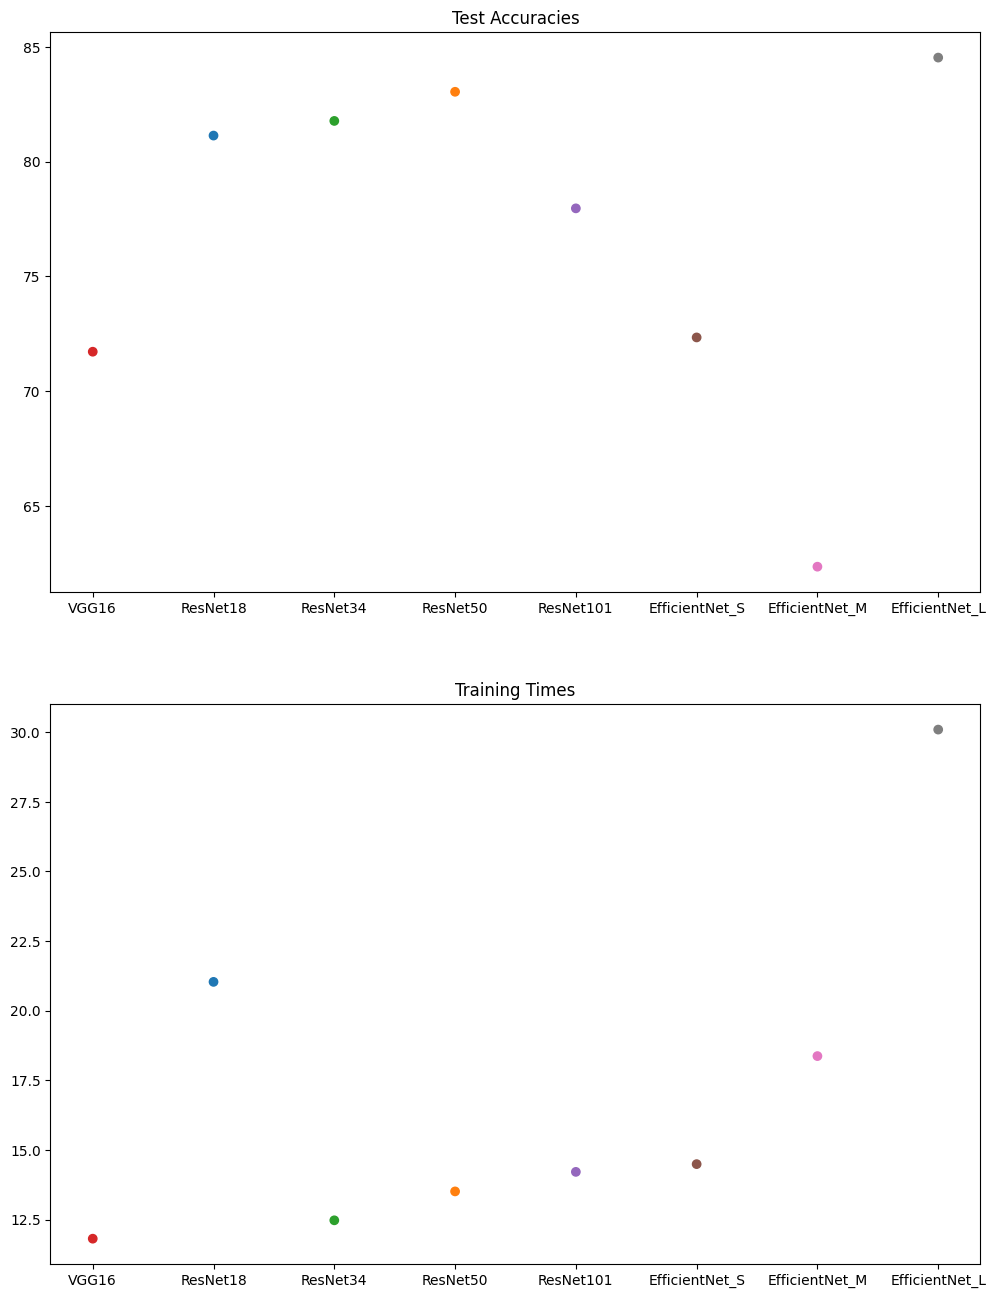

In [21]:
# plot
plt.figure(figsize=(12, 16))
plt.subplot(211)
plt.title('Test Accuracies')
plt.scatter(names, test_acc, color=colours)
plt.subplot(212)
plt.title('Training Times')
plt.scatter(names, time_taken, color=colours)
plt.show()

In [22]:
# collate results into dataframe
df = pd.DataFrame(
    np.column_stack([
        test_acc,
        time_taken
    ]),
    columns=['Test Accuracy', 'Training Time'],
    index=names
)
df

,Test Accuracy,Training Time
VGG16,71.721939,11.812752
ResNet18,81.135204,21.034877
ResNet34,81.772959,12.472394
ResNet50,83.042092,13.510472
ResNet101,77.965561,14.211886
EfficientNet_S,72.343750,14.490273
EfficientNet_M,62.359694,18.370055
EfficientNet_L,84.531250,30.094582
